In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


## Data preparation

In [3]:
# df_gdp = pd.read_csv("../gdp_analysis/results/gdp_weighted_pop_fifty.csv")
df_gdp = pd.read_csv("data/gdp_weighted_pop_decade.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name"})

### Check distribution of the data

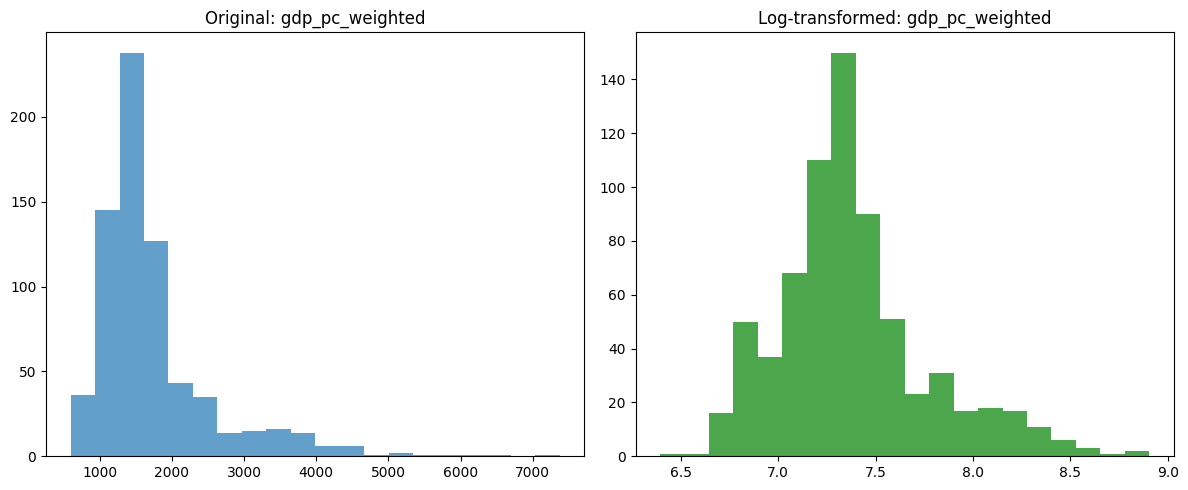

Original data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = 2.36242 (Highly skewed)

Log-transformed data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = 0.88633 (Moderately skewed)

➡️ RECOMMENDATION: Apply log transformation to gdp_pc_weighted


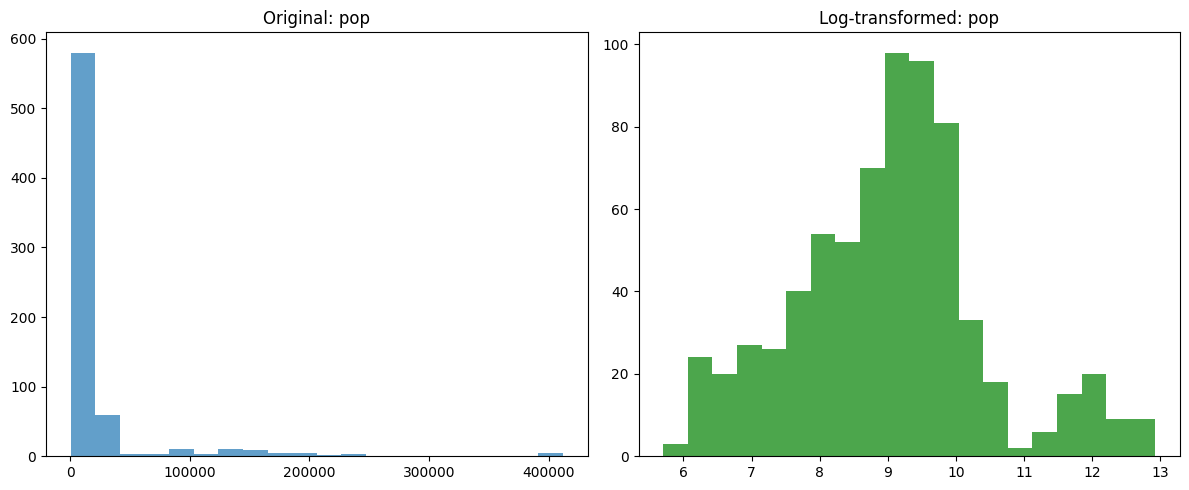

Original data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = 4.33901 (Highly skewed)

Log-transformed data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = 0.27207 (Symmetric)

➡️ RECOMMENDATION: Apply log transformation to pop


In [4]:

from scipy import stats
import warnings
warnings.filterwarnings('ignore')



for var in ['gdp_pc_weighted', 'pop']:

    
    data_gdp = df_gdp[var]

    # Statistical test for normality (Shapiro-Wilk test)
    stat, p_value = stats.shapiro(data_gdp)
    is_normal = p_value > 0.05

    # Calculate skewness
    skewness = stats.skew(data_gdp)


    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Original distribution
    ax1.hist(data_gdp, bins=20, alpha=0.7)
    ax1.set_title(f'Original: {var}')


    # Log transformation (handling zeros/negatives)
    if data_gdp.min() <= 0:
        log_data = np.log(data_gdp - data_gdp.min() + 1)  # log(x+1) after shifting
    else:
        log_data = np.log(data_gdp)

    # Log-transformed distribution
    ax2.hist(log_data, bins=20, alpha=0.7, color='green')
    ax2.set_title(f'Log-transformed: {var}')


    plt.tight_layout()
    plt.show()

    # Shapiro-Wilk test on log-transformed data
    log_stat, log_p_value = stats.shapiro(log_data)
    log_is_normal = log_p_value > 0.05

    # Check skewness of log-transformed data
    log_skewness = stats.skew(log_data)

    # Print results
    print(f"Original data:")
    print(f"  Shapiro-Wilk test: p-value = {p_value:.5f} ({'Normal' if is_normal else 'NOT normal'})")
    print(f"  Skewness = {skewness:.5f} ({'Symmetric' if abs(skewness) < 0.5 else 'Moderately skewed' if abs(skewness) < 1 else 'Highly skewed'})")
    print(f"\nLog-transformed data:")
    print(f"  Shapiro-Wilk test: p-value = {log_p_value:.5f} ({'Normal' if log_is_normal else 'NOT normal'})")
    print(f"  Skewness = {log_skewness:.5f} ({'Symmetric' if abs(log_skewness) < 0.5 else 'Moderately skewed' if abs(log_skewness) < 1 else 'Highly skewed'})")

    # Final recommendation
    needs_log = not is_normal and (log_is_normal or abs(log_skewness) < abs(skewness))

    if needs_log:
        print(f"\n➡️ RECOMMENDATION: Apply log transformation to {var}")
    else:
        print(f"\n✓ No log transformation needed for {var}")
        


## Transform the data

In [9]:


#df_cultura = pd.read_csv("../unseen_species_model/results/occupation/raw_results.csv", index_col = [0])
#df_cultura = pd.read_csv("../unseen_species_model/results_50/raw_results.csv", index_col = [0])

# Load Unseen-species data
# path = 'unseen_species_model/unseen_species_model.csv'
# path = 'unseen_species_model/unseen_species_model_no_occupation.csv'

path = '../3-unseen_species_index/unseen_species_model/unseen_species_model_bayesian.csv'

df_cultura = pd.read_csv(path, index_col = [0])
# df_cultura = df_cultura.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})

df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']

In [10]:


df = pd.merge(df_gdp, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year', 'gdp_pc_weighted':'gdp_per_capita'})


df['score_cap'] = df['score']/df['pop']
df['N_est_cap'] = df['N_est']/df['pop']


list(set(df.region_name))
df.region_name.value_counts()

keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

# Apply normalization

from scipy import stats

df["century"] = df["year"].round(-2)


df["score_log"] = np.log(df["score"])
df["score_log_std"] =  stats.zscore(df["score_log"])

df["score_cap_log"] = np.log(df["score_cap"])
df["score_cap_log_std"] = stats.zscore(df["score_cap_log"])

df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["N_est_cap_log_std"] = stats.zscore(df["N_est_cap_log"])  # Z-score


df["N_est_std"] = stats.zscore(df["N_est"])  # Z-score 
df["N_est_log_std"] = stats.zscore(df["N_est_log"])  # Z-score

df["log_gdp"] = np.log(df["gdp_per_capita"])

# df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df[f"log_gdp_std"] = stats.zscore(df["log_gdp"])  # Z-score


df["gdp_std"] = df["gdp_per_capita"] / df["gdp_per_capita"].mean()

df["gdp_std"] = stats.zscore(df["gdp_per_capita"])  # Z-score


df["survival_ratio_std"] = stats.zscore(df["survival_ratio"]) 
df['pop_log'] =  np.log(df["pop"])
# df["pop_log_std"] = df["pop_log"] / df["pop_log"].mean()

df["pop_log_std"] = stats.zscore(df["pop_log"])  # Z-score

# N_est calculations
df["N_est_log"] = np.log(df["N_est"])

# Variable calculations
#df[f"log_{var}_std"] = stats.zscore(df[f"log_{var}"])  # Z-score



In [11]:
tables_dict = {}

df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std', 'pop_log_std']].copy()

df_ols

,region_name,year,log_gdp_std,N_est_log_std,score_log_std,pop_log_std
0,Arabic world,730,-0.780640,-1.260806,-1.054701,-0.673104
1,Arabic world,1000,-1.228167,-1.533255,-1.201926,-0.632631
2,Arabic world,1120,-1.216873,-1.213085,-0.847199,-0.680821
3,Arabic world,1280,-1.197875,-0.813820,-0.537001,-0.471247
4,Arabic world,1300,-1.456566,-1.035899,-0.768310,-0.477386
...,...,...,...,...,...,...
509,United Kingdom,1840,2.416533,1.425216,1.737132,0.746959
510,United Kingdom,1850,2.747663,1.426865,1.722153,0.765546
511,United Kingdom,1860,3.057646,1.527699,1.839828,0.799557
512,United Kingdom,1870,3.399436,1.405449,1.723839,0.855546


🚀 Starting optimal lag analysis for GDP → Culture causality...
🔍 GRANGER CAUSALITY LAG OPTIMIZATION
Research Question: If GDP changes, how many years later do we see cultural changes?
Method: Test GDP → Culture causality at different lag lengths

📍 Arabic world
  ⚠️  Skipping - only 9 observations

📍 Chinese world
  📊 Data: 46 obs, 1000-1870
  🧪 Testing lags 1-8
    Lag 1: Error - grangercausalitytests() got an unexpected keyword argument 'maxlags'
    Lag 2: Error - grangercausalitytests() got an unexpected keyword argument 'maxlags'
    Lag 3: Error - grangercausalitytests() got an unexpected keyword argument 'maxlags'
    Lag 4: Error - grangercausalitytests() got an unexpected keyword argument 'maxlags'
    Lag 5: Error - grangercausalitytests() got an unexpected keyword argument 'maxlags'
    Lag 6: Error - grangercausalitytests() got an unexpected keyword argument 'maxlags'
    Lag 7: Error - grangercausalitytests() got an unexpected keyword argument 'maxlags'
    Lag 8: Error - 

In [16]:
df_ols[df_ols['region_name']=='United Kingdom']

,region_name,year,log_gdp_std,N_est_log_std,score_log_std,pop_log_std
450,United Kingdom,1000,-0.992313,-2.145385,-1.764156,-1.012271
451,United Kingdom,1250,-0.612566,-2.040809,-1.764156,-0.741140
452,United Kingdom,1260,-0.764089,-1.116646,-0.768310,-0.734984
453,United Kingdom,1270,-0.819681,-2.021552,-1.764156,-0.726286
454,United Kingdom,1280,-1.058176,-0.985944,-0.585777,-0.717698
...,...,...,...,...,...,...
509,United Kingdom,1840,2.416533,1.425216,1.737132,0.746959
510,United Kingdom,1850,2.747663,1.426865,1.722153,0.765546
511,United Kingdom,1860,3.057646,1.527699,1.839828,0.799557
512,United Kingdom,1870,3.399436,1.405449,1.723839,0.855546


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 482     Method:             REML       
No. Groups:       16      Scale:              0.2441     
Min. group size:  1       Log-Likelihood:     -377.4315  
Max. group size:  60      Converged:          Yes        
Mean group size:  30.1                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.311    0.217 -1.432 0.152 -0.737  0.115
N_est_log_std   0.405    0.030 13.298 0.000  0.345  0.465
Group Var       0.705    0.572                           



(0.0, 1.0, 0.0, 1.0)

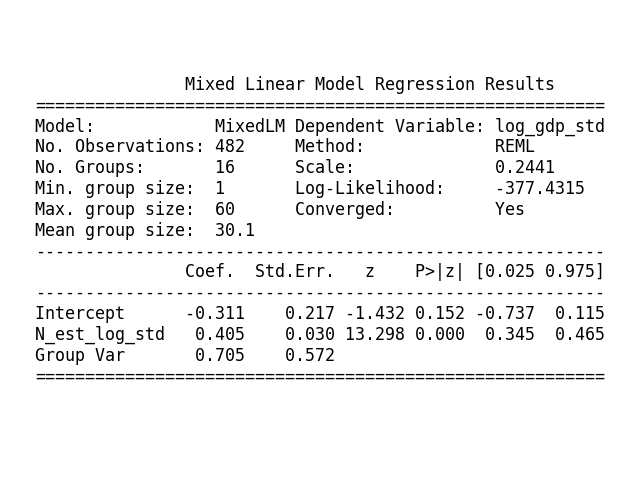

In [21]:


# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()


sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Cultural Production'
sm_table = sm_table.reset_index()
tables_dict['Cultural Production'] = sm_table


# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())


# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

# plt.savefig('model_summary.png', dpi=300, bbox_inches='tight', pad_inches=0.5)


#### Proper Regression Table

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the dataframe 'df_ols' is correctly set up from previous examples and ready to use
# Fit Mixed Effects Model (with region as a random effect)
mixed_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result_mixed = mixed_model.fit()

# Fit OLS Model (without fixed effects)
ols_model = smf.ols("log_gdp_std ~ N_est_log_std", df_ols)
result_ols = ols_model.fit()


# Calculate the correlation coefficient for the OLS model (without fixed effects)
correlation_ols = df_ols['log_gdp_std'].corr(df_ols['N_est_log_std'])

# Calculate correlation coefficients for each group in the mixed effects model and take the average
grouped = df_ols.groupby('region_name')
correlation_mixed = grouped.apply(lambda g: g['log_gdp_std'].corr(g['N_est_log_std'])).mean()


# Calculate R-squared for OLS model
r_squared_ols = result_ols.rsquared

# Calculate pseudo-R-squared for Mixed Model


# Assuming the model results and other variables (correlation_ols, correlation_mixed, etc.) are already available
results_df = pd.DataFrame({
    'Model': ['OLS Without FE', 'MixedLM With FE'],
    'Intercept': [f"{result_ols.params['Intercept']:.2f} ({result_ols.bse['Intercept']:.2f})", 
                  f"{result_mixed.params['Intercept']:.2f} ({result_mixed.bse['Intercept']:.2f})"],
    'CPI Coef': [f"{result_ols.params['N_est_log_std']:.2f} ({result_ols.bse['N_est_log_std']:.2f})", 
                 f"{result_mixed.params['N_est_log_std']:.2f} ({result_mixed.bse['N_est_log_std']:.2f})"],
    'CPI p-value': [f"{result_ols.pvalues['N_est_log_std']:.2f}", f"{result_mixed.pvalues['N_est_log_std']:.2f}"],
    'Log-Likelihood': [f"{result_ols.llf:.2f}", f"{result_mixed.llf:.2f}"],
    'Correlation': [f"{correlation_ols:.2f}", f"{correlation_mixed:.2f}"],
    'N': [f"{result_ols.nobs}", f"{result_mixed.nobs}"],
    'R-squared': [f"{result_ols.rsquared:.2f}", "N/A"]
})

# Transpose the DataFrame for the desired format
results_df = results_df.T
results_df.columns = results_df.iloc[0]  # Set the first row as column headers
results_df = results_df[1:]  # Remove the first row as it's now redundant

results_df

Model,OLS Without FE,MixedLM With FE
Intercept,-0.00 (0.04),-0.31 (0.22)
CPI Coef,0.45 (0.04),0.40 (0.03)
CPI p-value,0.00,0.00
Log-Likelihood,-629.54,-377.43
Correlation,0.45,0.23
N,482.0,482
R-squared,0.20,N/A


### Regression table (to mix with HDI measdures)

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

# Assuming the dataframe 'df_ols' is correctly set up from previous examples and ready to use
# Variable 'var' needs to be defined (e.g., var = 'some_variable_name')


var = 'gdp'

# df_ols.drop('score_log_std', axis=1).to_csv(f'df_indicators_hdi/data_for_regression/{var}.csv')

# Fit Mixed Effects Model (with region as a random effect)
mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result_mixed = mixed_model.fit()

# Fit OLS Model (without fixed effects)
ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", df_ols)
result_ols = ols_model.fit()

# Calculate the correlation coefficient for the OLS model (without fixed effects)
correlation_ols = df_ols['N_est_log_std'].corr(df_ols[f"log_{var}_std"])

# Calculate correlation coefficients for each group in the mixed effects model and take the average
grouped = df_ols.groupby('region_name')
correlation_mixed = grouped.apply(lambda g: g['N_est_log_std'].corr(g[f"log_{var}_std"])).mean()

# Prepare the results dataframe
results_df = pd.DataFrame({
    'Model': ['OLS Without FE', 'MixedLM With FE'],
    'Intercept': [f"{result_ols.params['Intercept']:.2f}", f"{result_mixed.params['Intercept']:.2f}"],
    'Intercept_SE': [f"{result_ols.bse['Intercept']:.2f}", f"{result_mixed.bse['Intercept']:.2f}"],
    'Intercept_CI': [f"({result_ols.conf_int().loc['Intercept'][0]:.2f}, {result_ols.conf_int().loc['Intercept'][1]:.2f})", 
                     f"({result_mixed.conf_int().loc['Intercept'][0]:.2f}, {result_mixed.conf_int().loc['Intercept'][1]:.2f})"],
    'Intercept_t-value': [f"{result_ols.tvalues['Intercept']:.2f}", f"{result_mixed.tvalues['Intercept']:.2f}"],
    'Coef': [f"{result_ols.params['N_est_log_std']:.2f}", f"{result_mixed.params['N_est_log_std']:.2f}"],
    'Coef_SE': [f"{result_ols.bse['N_est_log_std']:.2f}", f"{result_mixed.bse['N_est_log_std']:.2f}"],
    'Coef_CI': [f"({result_ols.conf_int().loc['N_est_log_std'][0]:.2f}, {result_ols.conf_int().loc['N_est_log_std'][1]:.2f})", 
                f"({result_mixed.conf_int().loc['N_est_log_std'][0]:.2f}, {result_mixed.conf_int().loc['N_est_log_std'][1]:.2f})"],
    'Coef_t-value': [f"{result_ols.tvalues['N_est_log_std']:.2f}", f"{result_mixed.tvalues['N_est_log_std']:.2f}"],
    'Coef_p-value': [f"{result_ols.pvalues['N_est_log_std']:.3f}", f"{result_mixed.pvalues['N_est_log_std']:.3f}"],
    'Log-Likelihood': [f"{result_ols.llf:.2f}", f"{result_mixed.llf:.2f}"],
    'Correlation': [f"{correlation_ols:.2f}", f"{correlation_mixed:.2f}"],
    'N': [f"{result_ols.nobs:.0f}", f"{result_mixed.nobs:.0f}"],
    'R-squared': [f"{result_ols.rsquared:.2f}", "N/A"]
})

# Transpose the DataFrame for the desired format and add variable name
results_df = results_df.T
results_df.columns = results_df.iloc[0]  # Set the first row as column headers
results_df = results_df[1:]  # Remove the first row as it's now redundant
results_df['Variable'] = var

# Save the results to a CSV file
results_df.to_csv(f'data/regression_table_{var}.csv')

# Print the results
results_df


Model,OLS Without FE,MixedLM With FE,Variable
Intercept,-0.00,-0.31,gdp
Intercept_SE,0.04,0.22,gdp
Intercept_CI,"(-0.08, 0.08)","(-0.74, 0.11)",gdp
Intercept_t-value,-0.00,-1.43,gdp
Coef,0.45,0.40,gdp
Coef_SE,0.04,0.03,gdp
Coef_CI,"(0.37, 0.53)","(0.35, 0.46)",gdp
Coef_t-value,11.02,13.30,gdp
Coef_p-value,0.000,0.000,gdp
Log-Likelihood,-629.54,-377.43,gdp


### Proper table with population Data

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

# Assuming the dataframe 'df_ols' is correctly set up from previous examples and ready to use
# Variable 'var' needs to be defined (e.g., var = 'some_variable_name')

var = 'gdp'

# df_ols.drop('score_log_std', axis=1).to_csv(f'df_indicators_hdi/data_for_regression/{var}.csv')

# Fit Mixed Effects Model (with region as a random effect)
mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std + pop_log_std", df_ols, groups=df_ols["region_name"])
result_mixed = mixed_model.fit()

# Fit OLS Model (without fixed effects)
ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", df_ols)
result_ols = ols_model.fit()

# Calculate the correlation coefficient for the OLS model (without fixed effects)
correlation_ols = df_ols['N_est_log_std'].corr(df_ols[f"log_{var}_std"])

# Calculate correlation coefficients for each group in the mixed effects model and take the average
grouped = df_ols.groupby('region_name')
correlation_mixed = grouped.apply(lambda g: g['N_est_log_std'].corr(g[f"log_{var}_std"])).mean()

# Prepare the results dataframe
results_df = pd.DataFrame({
    'Model': ['OLS Without FE', 'MixedLM With FE'],
    'Intercept': [f"{result_ols.params['Intercept']:.2f}", f"{result_mixed.params['Intercept']:.2f}"],
    'Intercept_SE': [f"{result_ols.bse['Intercept']:.2f}", f"{result_mixed.bse['Intercept']:.2f}"],
    'Intercept_CI': [f"({result_ols.conf_int().loc['Intercept'][0]:.2f}, {result_ols.conf_int().loc['Intercept'][1]:.2f})", 
                     f"({result_mixed.conf_int().loc['Intercept'][0]:.2f}, {result_mixed.conf_int().loc['Intercept'][1]:.2f})"],
    'Intercept_t-value': [f"{result_ols.tvalues['Intercept']:.2f}", f"{result_mixed.tvalues['Intercept']:.2f}"],
    'Coef': [f"{result_ols.params['N_est_log_std']:.2f}", f"{result_mixed.params['N_est_log_std']:.2f}"],
    'Coef_SE': [f"{result_ols.bse['N_est_log_std']:.2f}", f"{result_mixed.bse['N_est_log_std']:.2f}"],
    'Coef_CI': [f"({result_ols.conf_int().loc['N_est_log_std'][0]:.2f}, {result_ols.conf_int().loc['N_est_log_std'][1]:.2f})", 
                f"({result_mixed.conf_int().loc['N_est_log_std'][0]:.2f}, {result_mixed.conf_int().loc['N_est_log_std'][1]:.2f})"],
    'Coef_t-value': [f"{result_ols.tvalues['N_est_log_std']:.2f}", f"{result_mixed.tvalues['N_est_log_std']:.2f}"],
    'Coef_p-value': [f"{result_ols.pvalues['N_est_log_std']:.3f}", f"{result_mixed.pvalues['N_est_log_std']:.3f}"],
    'Log-Likelihood': [f"{result_ols.llf:.2f}", f"{result_mixed.llf:.2f}"],
    'Correlation': [f"{correlation_ols:.2f}", f"{correlation_mixed:.2f}"],
    'N': [f"{result_ols.nobs:.0f}", f"{result_mixed.nobs:.0f}"],
    'R-squared': [f"{result_ols.rsquared:.2f}", "N/A"]
})

# Transpose the DataFrame for the desired format and add variable name
results_df = results_df.T
results_df.columns = results_df.iloc[0]  # Set the first row as column headers
results_df = results_df[1:]  # Remove the first row as it's now redundant
results_df['Variable'] = var

# Save the results to a CSV file
#results_df.to_csv(f'data/regression_table_{var}.csv')

# Print the results
results_df.to_csv(f'data/regression_table_{var}_pop.csv')


                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     169.9
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           9.56e-34
Time:                        11:55:08   Log-Likelihood:                -655.67
No. Observations:                 514   AIC:                             1315.
Df Residuals:                     512   BIC:                             1324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.065e-15      0.038      8e-14

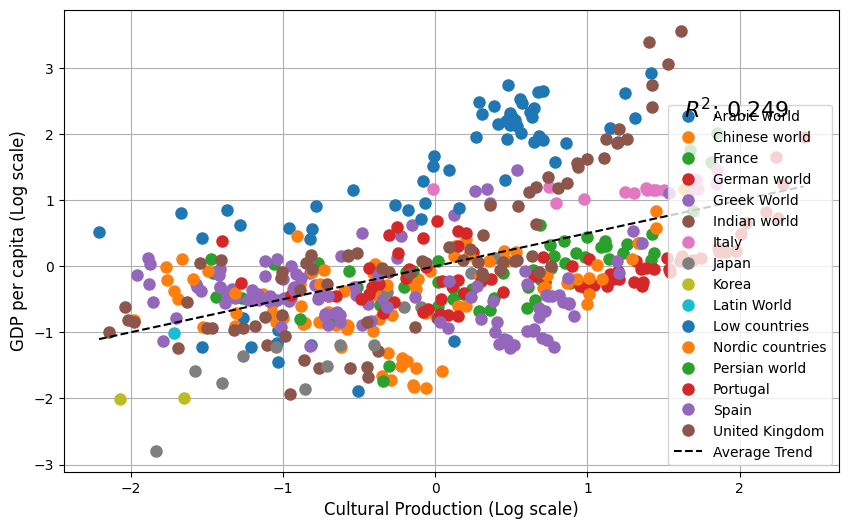

In [87]:


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['N_est_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Cultural Production (Log scale)', fontsize=12)
plt.ylabel('GDP per capita (Log scale)', fontsize=12)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

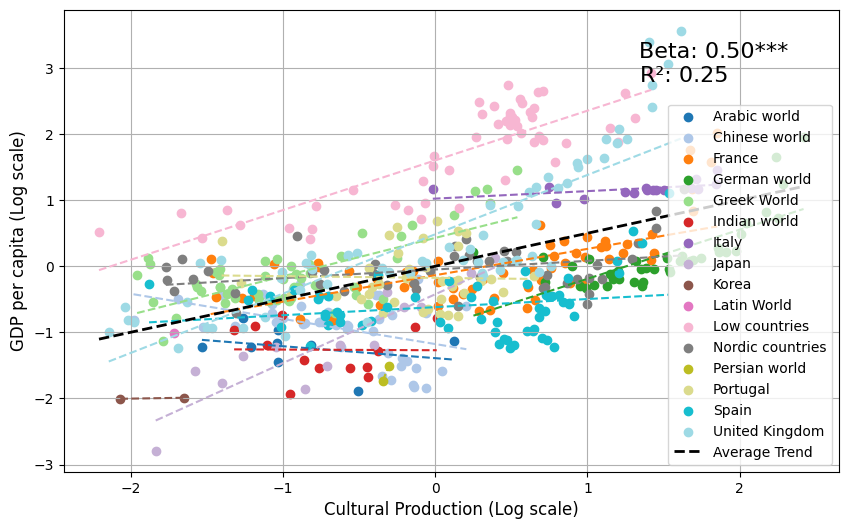

In [88]:
cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['N_est_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['N_est_log_std'].min(), group['N_est_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['N_est_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Cultural Production (Log scale)', fontsize=12)
plt.ylabel('GDP per capita (Log scale)', fontsize=12)
plt.title('')
plt.grid(True)

# Display coefficient and its significance for the average trend line
beta = average_ols_model.params['N_est_log_std']
p_value = average_ols_model.pvalues['N_est_log_std']
r_squared = average_ols_model.rsquared
significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
plt.figtext(0.85, 0.8, f'Beta: {beta:.2f}{significance}', ha='right', fontsize=16)
plt.figtext(0.79, 0.76, f'R²: {r_squared:.2f}', ha='right', fontsize=16)

plt.show()

## CPI

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 514     Method:             REML       
No. Groups:       16      Scale:              0.2452     
Min. group size:  1       Log-Likelihood:     -401.1792  
Max. group size:  64      Converged:          Yes        
Mean group size:  32.1                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.267    0.196 -1.362 0.173 -0.652  0.117
score_log_std   0.494    0.029 17.203 0.000  0.437  0.550
Group Var       0.581    0.457                           



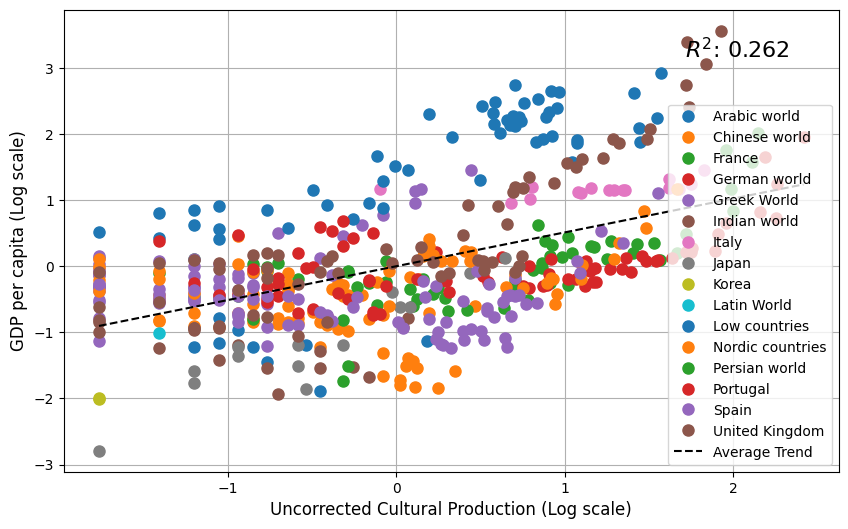

In [89]:
# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ score_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()


sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Uncorrected Cultural Production'
sm_table = sm_table.reset_index()
tables_dict['Uncorrected Cultural Production'] = sm_table

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['score_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Uncorrected Cultural Production (Log scale)', fontsize=12)
plt.ylabel('GDP per capita (Log scale)', fontsize=12)
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.8, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

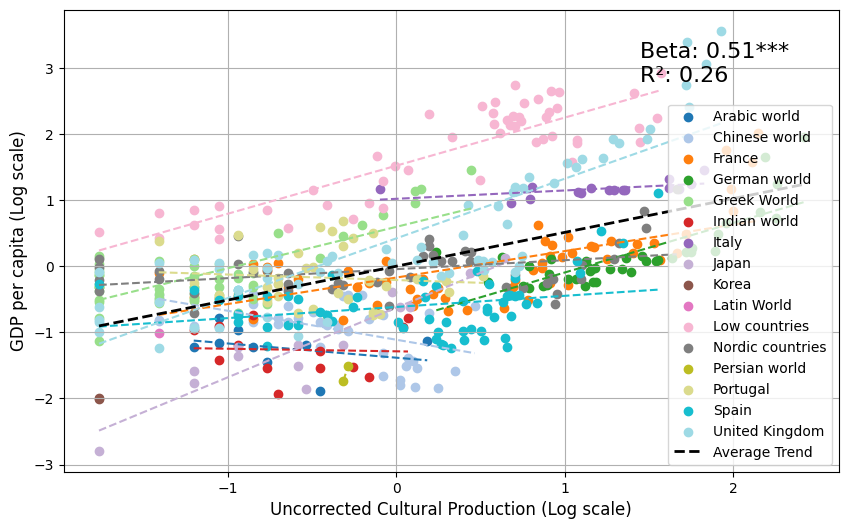

In [90]:
cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['score_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['score_log_std'].min(), group['score_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['score_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Uncorrected Cultural Production (Log scale)', fontsize=12)
plt.ylabel('GDP per capita (Log scale)', fontsize=12)
plt.title('')
plt.grid(True)

# Display coefficient and its significance for the average trend line
beta = average_ols_model.params['score_log_std']
p_value = average_ols_model.pvalues['score_log_std']
r_squared = average_ols_model.rsquared
significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
plt.figtext(0.85, 0.8, f'Beta: {beta:.2f}{significance}', ha='right', fontsize=16)
plt.figtext(0.79, 0.76, f'R²: {r_squared:.2f}', ha='right', fontsize=16)

plt.show()

## Corrected CPI 1800-1880

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 108     Method:             REML       
No. Groups:       15      Scale:              0.1159     
Min. group size:  2       Log-Likelihood:     -66.1897   
Max. group size:  9       Converged:          Yes        
Mean group size:  7.2                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.593    0.243 -2.441 0.015 -1.070 -0.117
N_est_log_std   1.228    0.120 10.243 0.000  0.993  1.463
Group Var       0.810    0.997                           

                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.510
Method:           

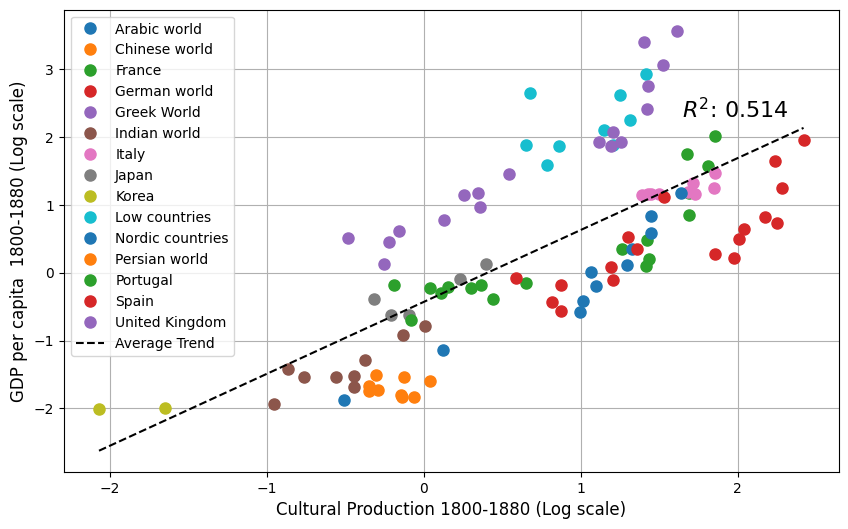

In [91]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std']].copy()
df_ols = df_ols[df_ols['year']>=1800]
df_ols.region_name.value_counts()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Cultural Production 1800-1880'
sm_table = sm_table.reset_index()
tables_dict['Cultural Production 1800-1880'] = sm_table


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['N_est_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Cultural Production 1800-1880 (Log scale)', fontsize=12)
plt.ylabel('GDP per capita  1800-1880 (Log scale)', fontsize=12)

plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared


plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 108     Method:             REML       
No. Groups:       15      Scale:              0.1159     
Min. group size:  2       Log-Likelihood:     -66.1897   
Max. group size:  9       Converged:          Yes        
Mean group size:  7.2                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.593    0.243 -2.441 0.015 -1.070 -0.117
N_est_log_std   1.228    0.120 10.243 0.000  0.993  1.463
Group Var       0.810    0.997                           

                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.510
Method:           

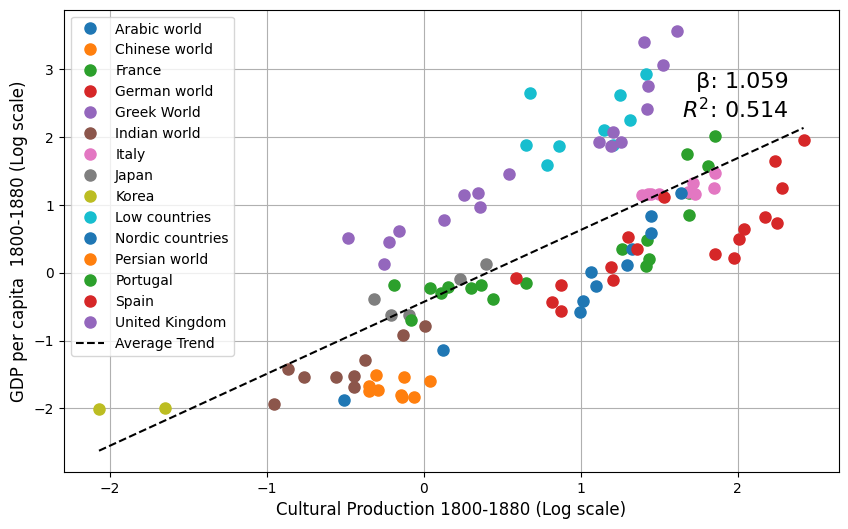

In [92]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std']].copy()
df_ols = df_ols[df_ols['year']>=1800]
df_ols.region_name.value_counts()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Cultural Production 1800-1880'
sm_table = sm_table.reset_index()
tables_dict['Cultural Production 1800-1880'] = sm_table


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['N_est_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Cultural Production 1800-1880 (Log scale)', fontsize=12)
plt.ylabel('GDP per capita  1800-1880 (Log scale)', fontsize=12)

plt.title('')
plt.grid(True)

# Show beta coefficient and R-squared on the plot for the average trend line
beta = average_ols_model.params['N_est_log_std']
r_squared = average_ols_model.rsquared

plt.figtext(0.85, 0.75, f'β: {beta:.3f}', ha='right', fontsize=16)
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

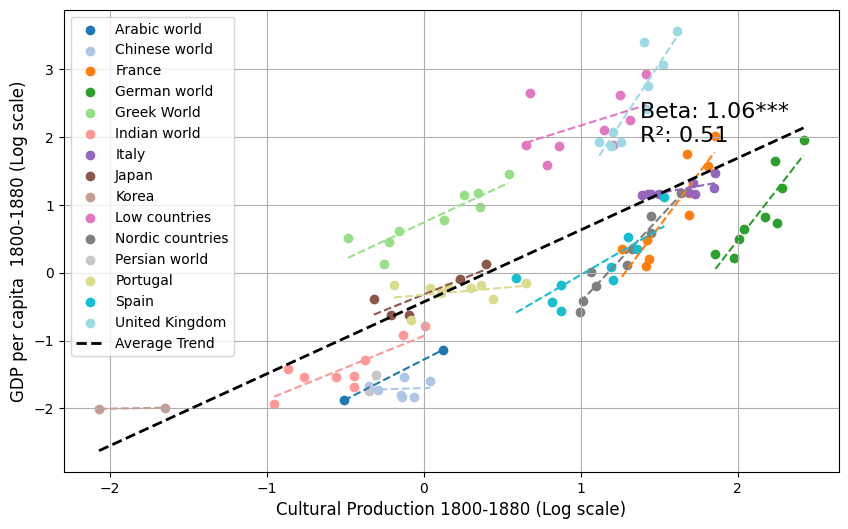

In [93]:
cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['N_est_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['N_est_log_std'].min(), group['N_est_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['N_est_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Cultural Production 1800-1880 (Log scale)', fontsize=12)
plt.ylabel('GDP per capita  1800-1880 (Log scale)', fontsize=12)
plt.title('')
plt.grid(True)

# Display coefficient and its significance for the average trend line
beta = average_ols_model.params['N_est_log_std']
p_value = average_ols_model.pvalues['N_est_log_std']
r_squared = average_ols_model.rsquared
significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
plt.figtext(0.85, 0.7, f'Beta: {beta:.2f}{significance}', ha='right', fontsize=16)
plt.figtext(0.79, 0.66, f'R²: {r_squared:.2f}', ha='right', fontsize=16)

plt.show()

## CPI 1800-1880

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 108     Method:             REML       
No. Groups:       15      Scale:              0.1212     
Min. group size:  2       Log-Likelihood:     -67.9390   
Max. group size:  9       Converged:          Yes        
Mean group size:  7.2                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.599    0.237 -2.531 0.011 -1.064 -0.135
score_log_std   1.105    0.110 10.059 0.000  0.890  1.321
Group Var       0.760    0.908                           

                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.525
Method:           

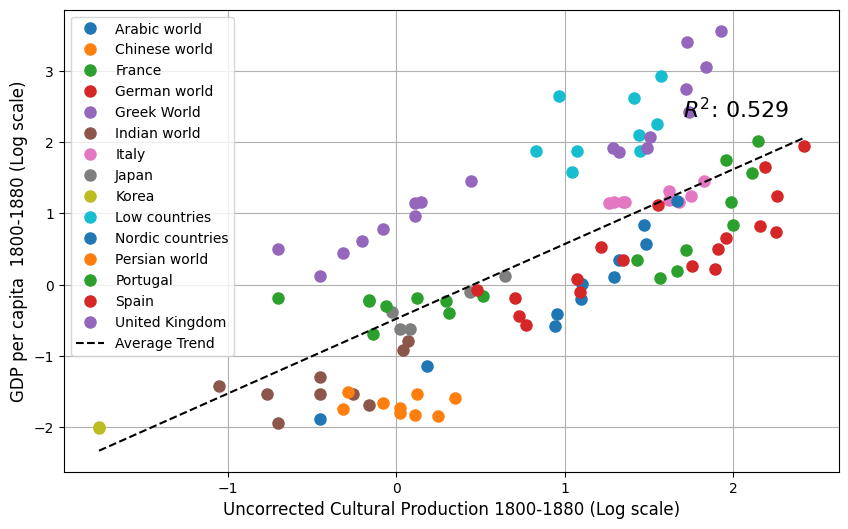

In [94]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std']].copy()
df_ols = df_ols[df_ols['year']>=1800]
df_ols.region_name.value_counts()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ score_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Uncorrected Cultural Production 1800-1880'
sm_table = sm_table.reset_index()
tables_dict['Uncorrected Cultural Production 1800-1880'] = sm_table


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['score_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Uncorrected Cultural Production 1800-1880 (Log scale)', fontsize=12)
plt.ylabel('GDP per capita  1800-1880 (Log scale)', fontsize=12)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared


plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 108     Method:             REML       
No. Groups:       15      Scale:              0.1212     
Min. group size:  2       Log-Likelihood:     -67.9390   
Max. group size:  9       Converged:          Yes        
Mean group size:  7.2                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.599    0.237 -2.531 0.011 -1.064 -0.135
score_log_std   1.105    0.110 10.059 0.000  0.890  1.321
Group Var       0.760    0.908                           

                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.525
Method:           

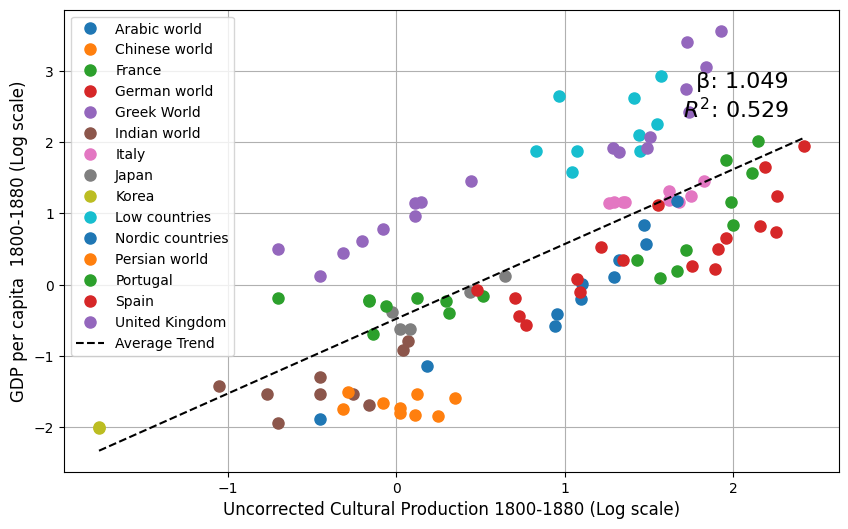

In [95]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std']].copy()
df_ols = df_ols[df_ols['year']>=1800]
df_ols.region_name.value_counts()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ score_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Uncorrected Cultural Production 1800-1880'
sm_table = sm_table.reset_index()
tables_dict['Uncorrected Cultural Production 1800-1880'] = sm_table


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['score_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Uncorrected Cultural Production 1800-1880 (Log scale)', fontsize=12)
plt.ylabel('GDP per capita  1800-1880 (Log scale)', fontsize=12)
plt.title('')
plt.grid(True)

# Show beta coefficient and R-squared on the plot for the average trend line
beta = average_ols_model.params['score_log_std']
r_squared = average_ols_model.rsquared

plt.figtext(0.85, 0.75, f'β: {beta:.3f}', ha='right', fontsize=16)
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

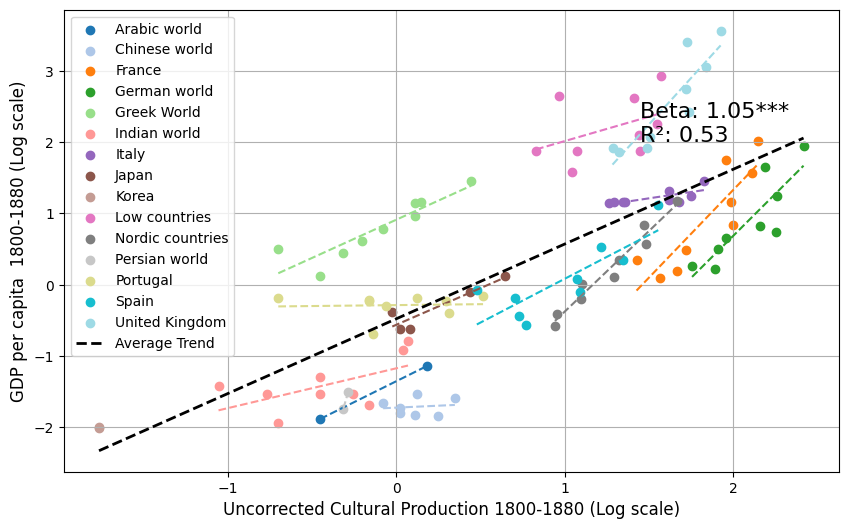

In [96]:
cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['score_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['score_log_std'].min(), group['score_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['score_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
    

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Uncorrected Cultural Production 1800-1880 (Log scale)', fontsize=12)
plt.ylabel('GDP per capita  1800-1880 (Log scale)', fontsize=12)
plt.title('')
plt.grid(True)

# Display coefficient and its significance for the average trend line
beta = average_ols_model.params['score_log_std']
p_value = average_ols_model.pvalues['score_log_std']
r_squared = average_ols_model.rsquared
significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
plt.figtext(0.85, 0.7, f'Beta: {beta:.2f}{significance}', ha='right', fontsize=16)
plt.figtext(0.79, 0.66, f'R²: {r_squared:.2f}', ha='right', fontsize=16)

plt.show()

## Population data

In [97]:
df_ols_pop = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std', 'pop_log_std']].copy()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std + pop_log_std", df_ols_pop, groups=df_ols_pop["region_name"])
result = model.fit()



sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'alpha_pop', 'Group Var']
sm_table['model'] = 'Cultural Production per capita'
sm_table = sm_table.reset_index()
tables_dict['Cultural Production per capita'] = sm_table

# Final tables

In [98]:
final_table = pd.concat(tables_dict.values(), ignore_index=True).reset_index(drop=True)
final_table = final_table[final_table['index']=='alpha']
final_table = final_table.drop(['index', 'z'], axis=1)
final_table = final_table.sort_values('Coef.', ascending=True)
final_table = final_table.rename(columns={'[0.025':'0.025', '0.975]':'0.975'})
list(final_table.columns)

final_table['Coef.'] = final_table['Coef.'].astype(float)
final_table['0.025'] = final_table['0.025'].astype(float)
final_table['0.975'] = final_table['0.975'].astype(float)
final_table['P>|z|'] = final_table['P>|z|'].astype(float)
final_table = final_table.reset_index(drop=True)
final_table['model'] = final_table['model'] + ' vs GDP per Capita'
final_table

,Coef.,Std.Err.,P>|z|,0.025,0.975,model
0,0.242,0.045,0.0,0.154,0.330,Cultural Production per capita vs GDP per Capita
1,0.472,0.030,0.0,0.414,0.531,Cultural Production vs GDP per Capita
2,0.494,0.029,0.0,0.437,0.550,Uncorrected Cultural Production vs GDP per Capita
3,1.105,0.110,0.0,0.890,1.321,Uncorrected Cultural Production 1800-1880 vs G...
4,1.228,0.120,0.0,0.993,1.463,Cultural Production 1800-1880 vs GDP per Capita


In [99]:



# final_table['model'] = [
#     "Cultural Production per capita vs GDP per Capita",
#     "Cultural Production vs GDP per Capita", 
#     "Uncorrected Cultural Production vs GDP per Capita",
#     "Uncorrected Cultural Production 1800-1880 vs GDP per Capita",
#     "Cultural Production 1800-1880 vs GDP per Capita"
# ]

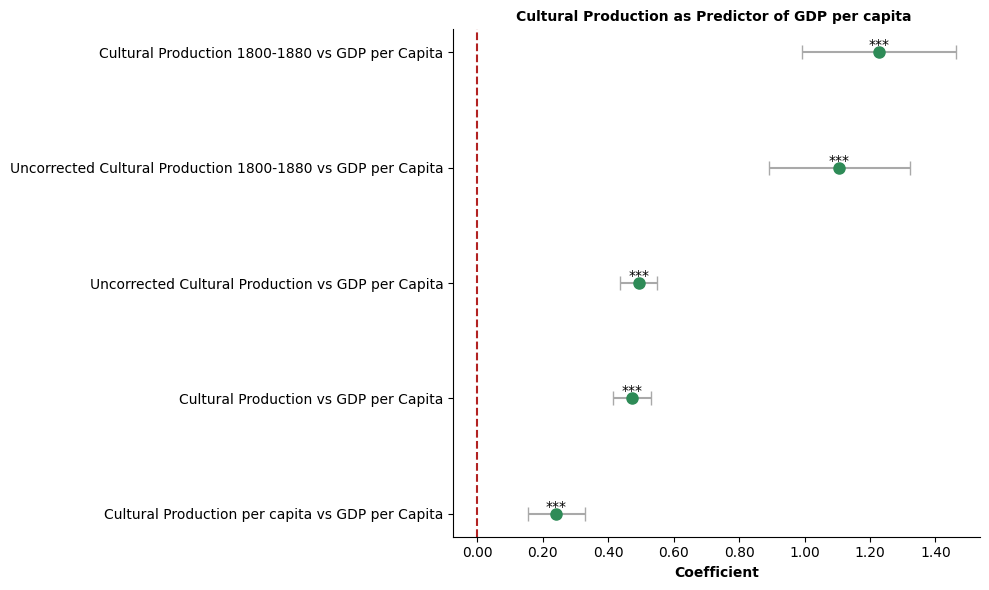

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for more models

# Plot the data points and error bars
ax.errorbar(final_table['Coef.'], final_table['model'], 
            xerr=[final_table['Coef.'] - final_table['0.025'], 
                  final_table['0.975'] - final_table['Coef.']],
            fmt='o', capsize=5, ecolor='darkgray', markersize=8, 
            color='seagreen', linewidth=1.5, zorder=2)

# Add a vertical line at x=0
ax.axvline(x=0, color='firebrick', linestyle='--', linewidth=1.5, zorder=1)

# Add *** on top of the green dots
for i, model in enumerate(final_table['model']):
    ax.text(final_table['Coef.'][i], model, '***', ha='center', va='bottom', color='black', fontsize=10)

# Customize the plot
ax.set_xlabel('Coefficient', fontweight='bold')
ax.set_ylabel('', fontweight='bold')
ax.set_title('Cultural Production as Predictor of GDP per capita ', fontsize=10, fontweight='bold')

# Adjust the x-axis to show more precision
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Population data

###  Checking for multicolinearity

In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming 'df' is your DataFrame and it contains all relevant predictors
X = add_constant(df[['N_est_log_std', 'pop_log_std']])  # adding a constant is essential for VIF calculation

VIF = pd.DataFrame()
VIF["Variable"] = X.columns
VIF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIF)


        Variable       VIF
0          const  1.000000
1  N_est_log_std  1.008684
2    pop_log_std  1.008684


In [102]:
# Assuming 'df' is your DataFrame
correlation_matrix = df[['N_est_log_std', 'pop_log_std']].corr()
correlation_matrix

,N_est_log_std,pop_log_std
N_est_log_std,1.000000,0.092785
pop_log_std,0.092785,1.000000


In [103]:
# sm_table.index = ['Intercept', 'CCPI', "Population",'Group Var']
# sm_table['model'] = 'Corrected CPI'
# sm_table = sm_table.reset_index()

# # Plotting the summary text
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
# ax.axis('off')  # Turn off the axis

# # plt.savefig('model_summary_pop_ccpi.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [104]:
# # Mixed Effects Model
# model = smf.mixedlm("log_gdp_std ~ score_log_std + pop_log_std", df_ols_pop, groups=df_ols_pop["region_name"])
# result = model.fit()

# print(result.summary())

# sm_table = result.summary().tables[1]
# sm_table.index = ['Intercept', 'CPI', "Population",'Group Var']
# sm_table['model'] = 'Corrected CPI'
# sm_table = sm_table.reset_index()

# # Plotting the summary text
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
# ax.axis('off')  # Turn off the axis

# plt.savefig('model_summary_pop_cpi.png', dpi=300, bbox_inches='tight', pad_inches=0.5)